In [1]:
import torch
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt
import torch.nn as nn
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import pandas as pd
import numpy as np
from PIL import Image

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
class FillToSquare:
    def __call__(self, image):
        s = image.size
        max_wh = max(s[-1], s[-2])
        hp = int((max_wh - s[-2])/2)
        vp = int((max_wh - s[-1])/2)
        padding = (hp, vp, hp, vp)
        return F.pad(image, padding, 0, 'constant')

In [3]:
train_aug = transforms.Compose([
    #FillToSquare(),
    #transforms.Resize((512,512)),
    transforms.RandomInvert(p=0.1),
    transforms.RandomRotation(degrees=3),
    transforms.CenterCrop(224),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

test_transforms =transforms.Compose([
    #FillToSquare(),
    #transforms.Resize((512,512)),
    transforms.CenterCrop(224),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

In [4]:
dataset_train = ImageFolder('/content/drive/MyDrive/font_recognition/images/train',
                      transform=train_aug)
dataset_test = ImageFolder('/content/drive/MyDrive/font_recognition/images/test',
                      transform=test_transforms)


In [5]:
train_loader = DataLoader(dataset_train, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset_test, batch_size=64, shuffle=False)

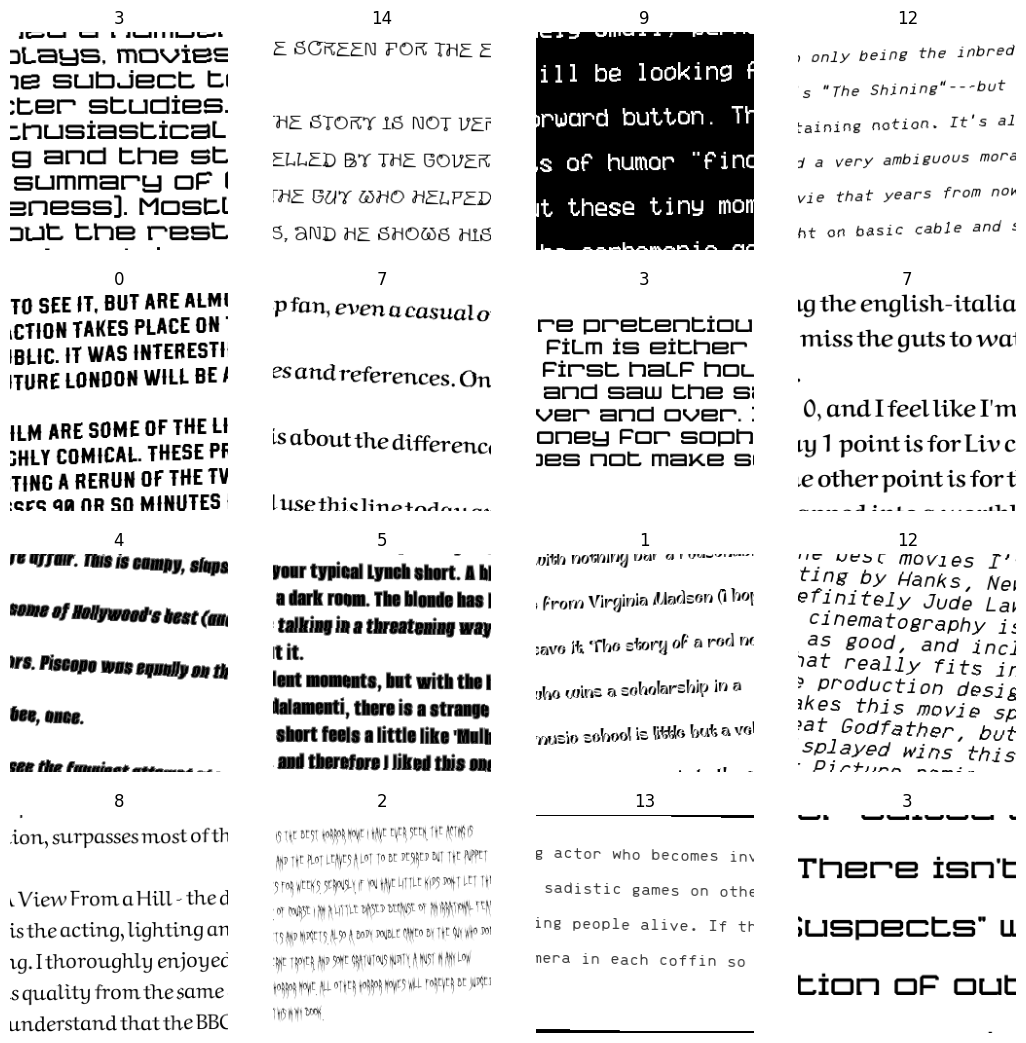

In [6]:
figure = plt.figure(figsize=(13, 13))
cols, rows = 4, 4
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(dataset_train), size=(1,)).item()
    img, label = dataset_train[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [7]:
num_epochs = 10
num_classes = 15
learning_rate = 0.001


In [8]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=0),
            nn.ReLU() ,
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2)) #, ceil_mode=True))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2)) #, ceil_mode=True))
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(54 * 54 * 64, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [10]:
model = ConvNet()
model.to(device)


ConvNet(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (drop_out): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=186624, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=15, bias=True)
)

In [11]:
from torchsummary import summary
summary(model, (1, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 222, 222]             320
              ReLU-2         [-1, 32, 222, 222]               0
       BatchNorm2d-3         [-1, 32, 222, 222]              64
         MaxPool2d-4         [-1, 32, 111, 111]               0
            Conv2d-5         [-1, 64, 109, 109]          18,496
              ReLU-6         [-1, 64, 109, 109]               0
       BatchNorm2d-7         [-1, 64, 109, 109]             128
         MaxPool2d-8           [-1, 64, 54, 54]               0
           Dropout-9               [-1, 186624]               0
           Linear-10                  [-1, 128]      23,888,000
           Linear-11                   [-1, 64]           8,256
           Linear-12                   [-1, 15]             975
Total params: 23,916,239
Trainable params: 23,916,239
Non-trainable params: 0
-------------------------

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [13]:
#Train
model.to(device)

total_step = len(train_loader)

train_metrics_list = []
test_metrics_list = []

for epoch in range(num_epochs):
    train_loss_list = []
    train_acc_list = []

    # Расчёт метрик мультиклассовой классификации
    train_all_labels = []
    train_all_predicted = []
    print(epoch)
    for i, (images, labels) in enumerate(train_loader):

        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        train_loss_list.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        train_acc_list.append(correct / total)

        train_all_labels.extend(labels.tolist())
        train_all_predicted.extend(predicted.tolist())

        if (i + 1) % 1 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                          (correct / total) * 100))

    train_losses = np.mean(train_loss_list)
    accuracy = accuracy_score(train_all_labels, train_all_predicted)
    precision, recall, f1, _ = precision_recall_fscore_support(train_all_labels, train_all_predicted, average='weighted')
    train_metrics_list.append({'epoch': epoch,'loss': train_losses,'accuracy': accuracy,'precision': precision, 'recall': recall, 'f1': f1})

    #Test
    model.eval()

    test_loss_list = []
    test_acc_list = []

    test_all_labels = []
    test_all_predicted = []
    for i, (images, labels) in enumerate(test_loader): 
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss_list.append(loss.item())

        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        test_acc_list.append(correct / total)

        test_all_labels.extend(labels.tolist())
        test_all_predicted.extend(predicted.tolist())

    test_losses = np.mean(test_loss_list)
    accuracy = accuracy_score(test_all_labels, test_all_predicted)
    precision, recall, f1, _ = precision_recall_fscore_support(test_all_labels, test_all_predicted, average='weighted')
    test_metrics_list.append({'epoch': epoch,'loss': test_losses, 'accuracy': accuracy,'precision': precision, 'recall': recall, 'f1': f1})


0
Epoch [1/10], Step [1/141], Loss: 2.8165, Accuracy: 4.69%
Epoch [1/10], Step [2/141], Loss: 66.4054, Accuracy: 7.81%
Epoch [1/10], Step [3/141], Loss: 75.0367, Accuracy: 6.25%
Epoch [1/10], Step [4/141], Loss: 51.9914, Accuracy: 9.38%
Epoch [1/10], Step [5/141], Loss: 73.9719, Accuracy: 9.38%
Epoch [1/10], Step [6/141], Loss: 68.9260, Accuracy: 7.81%
Epoch [1/10], Step [7/141], Loss: 51.8752, Accuracy: 6.25%
Epoch [1/10], Step [8/141], Loss: 53.2689, Accuracy: 6.25%
Epoch [1/10], Step [9/141], Loss: 56.7124, Accuracy: 3.12%
Epoch [1/10], Step [10/141], Loss: 57.2728, Accuracy: 12.50%
Epoch [1/10], Step [11/141], Loss: 46.1848, Accuracy: 7.81%
Epoch [1/10], Step [12/141], Loss: 53.1400, Accuracy: 7.81%
Epoch [1/10], Step [13/141], Loss: 42.9370, Accuracy: 10.94%
Epoch [1/10], Step [14/141], Loss: 46.8155, Accuracy: 4.69%
Epoch [1/10], Step [15/141], Loss: 46.1209, Accuracy: 10.94%
Epoch [1/10], Step [16/141], Loss: 31.7711, Accuracy: 12.50%
Epoch [1/10], Step [17/141], Loss: 33.2474, 

In [14]:
torch.save(model.state_dict(), '/content/drive/MyDrive/font_recognition/weights.pt')

In [18]:
train_metrics = pd.DataFrame.from_records(train_metrics_list)
train_metrics

,epoch,loss,accuracy,precision,recall,f1
0,0,13.667063,0.259440,0.258213,0.259440,0.258437
1,1,1.124258,0.660373,0.658659,0.660373,0.658619
2,2,0.631342,0.798312,0.797821,0.798312,0.797721
3,3,0.605301,0.820413,0.820599,0.820413,0.820260
4,4,0.366133,0.886162,0.886187,0.886162,0.886061
5,5,0.329031,0.898045,0.898078,0.898045,0.897987
6,6,0.361128,0.891715,0.891631,0.891715,0.891573
7,7,0.332589,0.903487,0.903511,0.903487,0.903462
8,8,0.318077,0.908041,0.908113,0.908041,0.908029
9,9,0.353243,0.900822,0.900955,0.900822,0.900828


In [19]:
test_metrics = pd.DataFrame.from_records(test_metrics_list)
test_metrics

,epoch,loss,accuracy,precision,recall,f1
0,0,2.446171,0.467271,0.565434,0.467271,0.458278
1,1,0.940179,0.675730,0.764318,0.675730,0.673966
2,2,0.614263,0.818731,0.865732,0.818731,0.829875
3,3,0.553345,0.835851,0.880773,0.835851,0.845574
4,4,0.431521,0.865055,0.902283,0.865055,0.872163
5,5,0.535421,0.878147,0.901786,0.878147,0.880428
6,6,0.416781,0.881168,0.894930,0.881168,0.883719
7,7,0.334643,0.914401,0.921571,0.914401,0.915046
8,8,0.437709,0.888218,0.903330,0.888218,0.885968
9,9,0.572649,0.880161,0.919498,0.880161,0.889949


In [20]:
#Log в csv
train_metrics.to_csv('/content/drive/MyDrive/font_recognition/train_metrics.csv', index=False)
test_metrics.to_csv('/content/drive/MyDrive/font_recognition/test_metrics.csv', index=False)

In [21]:
def plot_loss_metrics(train_metrics, test_metrics):
    fig, ax = plt.subplots(1,2, figsize=(14,5))
    ax[0].plot(train_metrics['loss'], label='Train loss')
    ax[0].plot(test_metrics['loss'], label='Test loss')
    ax[0].legend()
    ax[0].set_title('Loss')

    ax[1].plot(train_metrics['accuracy'], label='Train accuracy')
    ax[1].plot(test_metrics['accuracy'], label='Test accuracy')
    ax[1].legend()
    ax[1].set_title('Accuracy')

In [22]:
def plot_other(train_metrics, test_metrics):
    fig, ax = plt.subplots(1,3, figsize=(14,5))
    ax[0].plot(train_metrics['precision'], label='Train precision')
    ax[0].plot(test_metrics['precision'], label='Test precision')
    ax[0].legend()
    ax[0].set_title('Precision')

    ax[1].plot(train_metrics['recall'], label='Train recall')
    ax[1].plot(test_metrics['recall'], label='Test recall')
    ax[1].legend()
    ax[1].set_title('Recall')

    ax[2].plot(train_metrics['f1'], label='Train F1')
    ax[2].plot(test_metrics['f1'], label='Test F1')
    ax[2].legend()
    ax[2].set_title('F1-score')

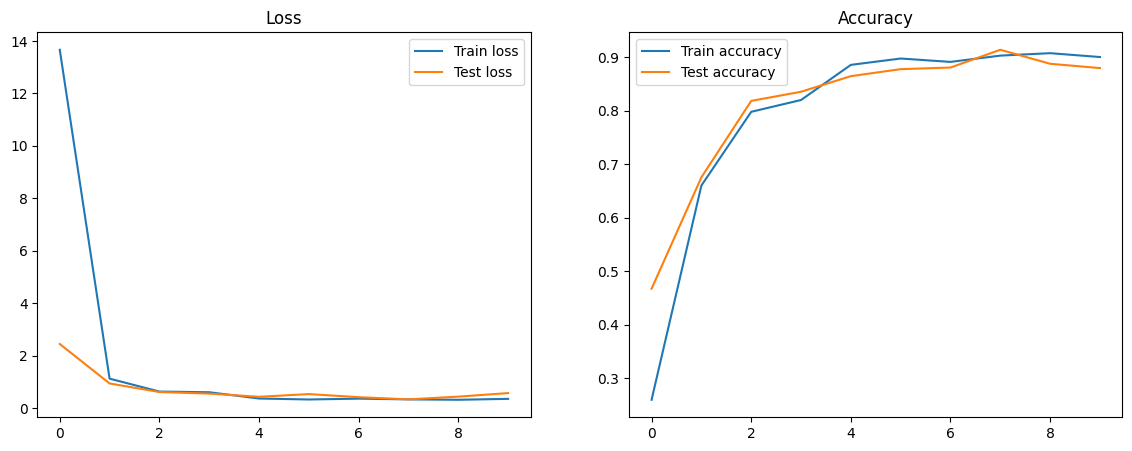

In [23]:
plot_loss_metrics(train_metrics, test_metrics)

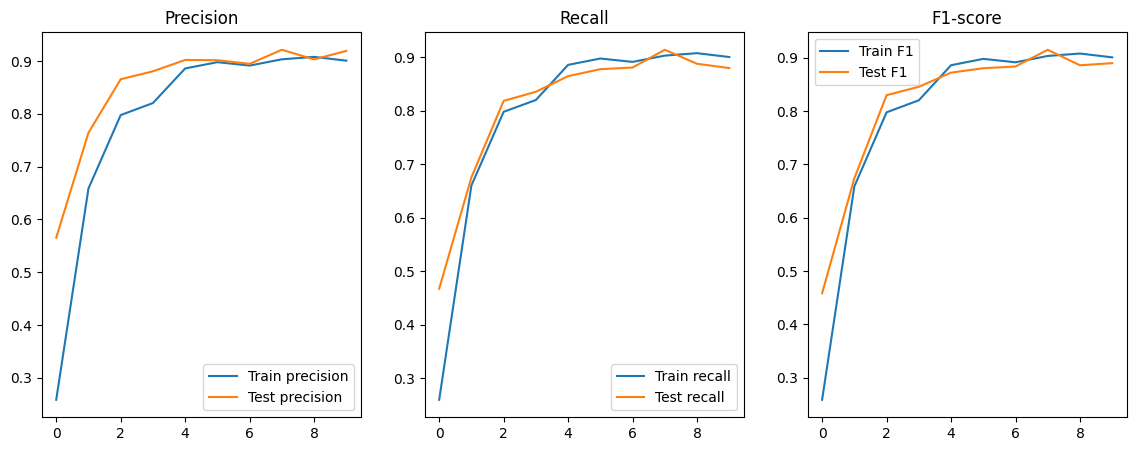

In [24]:
plot_other(train_metrics, test_metrics)